 # First machine learning project : Titanic
- Visualization of Dataset
- Completion of Dataset
- Determination of an adequate model, through the analysis of features' impact on the visualization.

# 1. Imports

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, GroupKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn import tree
from tqdm import tqdm

warnings.filterwarnings('ignore')

# 2. Import Data, formatting and visualization

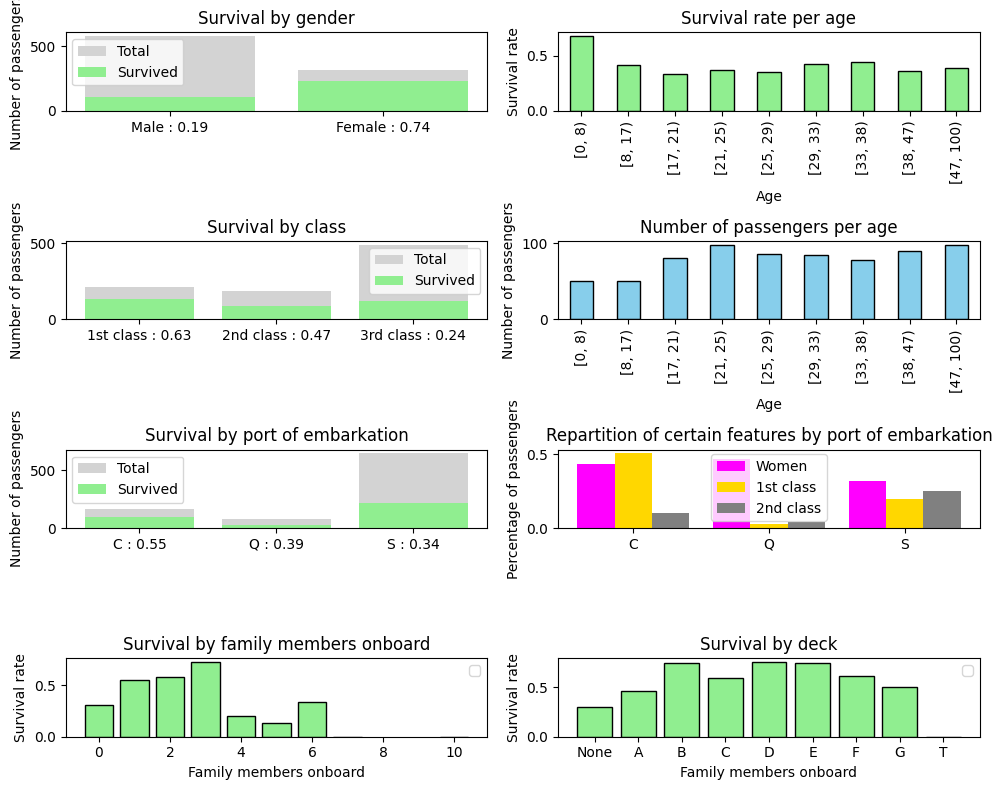

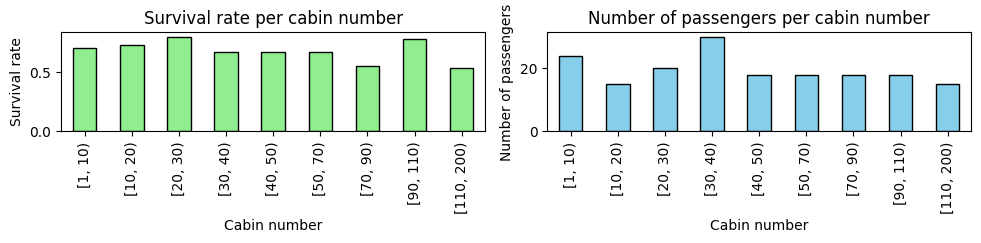

In [2]:
train_set_raw = pd.read_csv("Data/train.csv")
train_set = train_set_raw.copy()
# Formatting
def format_dataset(dataset):
    dataset['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    dataset['Embarked'].replace(['C', 'Q', 'S'], [0, 1, 2], inplace=True)
    dataset['Family'] = dataset['SibSp'] + dataset['Parch']
    dataset['Cabin_letter'] = dataset['Cabin'].str[0]
    dataset['Cabin_letter'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], [1, 2, 3, 4, 5, 6, 7, 8], inplace=True)
    dataset['Cabin_letter'].fillna(0, inplace=True)
    dataset['Cabin_number'] = dataset["Cabin"].str[1:]
    dataset['Cabin_number'] = pd.to_numeric(dataset['Cabin_number'], errors='coerce')
    dataset['Cabin_number'].fillna(0, inplace=True)
    return dataset

train_set = format_dataset(train_set)


## Visualizations
# Gender
plt.figure(figsize=(10, 8))
plt.subplot(421)
survival_sex = train_set.groupby('Sex')['Survived'].agg(['sum', 'count'])
survival_rate_gender = round(train_set.groupby('Sex')['Survived'].mean(), 2)
survival_sex.index = survival_sex.index.map({0 : f'Male : {survival_rate_gender[0]}', 1 : f'Female : {survival_rate_gender[1]}'})
plt.bar(survival_sex.index, survival_sex['count'], label='Total', color='lightgray')
plt.bar(survival_sex.index, survival_sex['sum'], label='Survived', color='lightgreen')
plt.title('Survival by gender')
plt.ylabel('Number of passengers')
plt.legend()

# Age
plt.subplot(422)
train_set['Age_bin'] = pd.cut(train_set['Age'], bins=[0, 8, 17, 21, 25, 29, 33, 38, 47, 100], right=False)
survival_by_age = train_set.groupby('Age_bin')['Survived'].mean()
survival_by_age.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.ylabel('Survival rate')
plt.xlabel('Age')
plt.title('Survival rate per age')

plt.subplot(424)
age_counts = train_set.groupby('Age_bin')['Age'].count()
age_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.title('Number of passengers per age')

# Pclass
plt.subplot(423)
survival_class = train_set.groupby('Pclass')['Survived'].agg(['sum', 'count'])
survival_rate_class = round(train_set.groupby('Pclass')['Survived'].mean(), 2)

survival_class.index = survival_class.index.map({1 : f'1st class : {survival_rate_class[1]}', 2 : f'2nd class : {survival_rate_class[2]}', 3: f'3rd class : {survival_rate_class[3]}'})
plt.bar(survival_class.index, survival_class['count'], label='Total', color='lightgray')
plt.bar(survival_class.index, survival_class['sum'], label='Survived', color='lightgreen')
plt.title('Survival by class')
plt.ylabel('Number of passengers')
plt.legend()

# Port of embarkation
plt.subplot(425)
survival_embarked = train_set.groupby('Embarked')['Survived'].agg(['sum', 'count'])
survival_rate_embarked = round(train_set.groupby('Embarked')['Survived'].mean(), 2)
survival_embarked.index = survival_embarked.index.map({0 : f'C : {survival_rate_embarked[0]}', 1 : f'Q : {survival_rate_embarked[1]}', 2 : f'S : {survival_rate_embarked[2]}'})
plt.bar(survival_embarked.index, survival_embarked['count'], label='Total', color='lightgray')
plt.bar(survival_embarked.index, survival_embarked['sum'], label='Survived', color='lightgreen')
plt.title('Survival by port of embarkation')
plt.ylabel('Number of passengers')
plt.legend()

plt.subplot(426)
women_port_repartition = train_set.groupby('Embarked')['Sex'].sum()/train_set.groupby('Embarked')['Embarked'].count()
pclass_port_repartition = train_set[train_set['Pclass'] == 1].groupby('Embarked').size()/train_set.groupby('Embarked')['Embarked'].count()
sclass_port_repartition = train_set[train_set['Pclass'] == 2].groupby('Embarked').size()/train_set.groupby('Embarked')['Embarked'].count()
sclass_port_repartition.index = pclass_port_repartition.index = women_port_repartition.index = pclass_port_repartition.index.map({0 : 'C', 1 : 'Q', 2 : 'S'})
x = np.arange(len(women_port_repartition))
width = 0.55
plt.bar(x - width/2, women_port_repartition.values, width/2, label='Women', color='fuchsia')
plt.bar(x, pclass_port_repartition.values, width/2, label='1st class', color='gold')
plt.bar(x + width/2, sclass_port_repartition.values, width/2, label='2nd class', color='gray')
plt.xticks(x, women_port_repartition.index)
plt.legend()
plt.title('Repartition of certain features by port of embarkation')
plt.ylabel('Percentage of passengers')

# Survival rate per size of family onboard
plt.subplot(427)
survival_family_rate = train_set.groupby('Family')['Survived'].mean()
plt.bar(survival_family_rate.index, survival_family_rate, color='lightgreen', edgecolor='black')
plt.title('Survival by family members onboard')
plt.ylabel('Survival rate')
plt.xlabel('Family members onboard')
plt.legend()

# Survival rate per deck
plt.subplot(428)
survival_deck_rate = train_set.groupby('Cabin_letter')['Survived'].mean()
survival_deck_rate.index = survival_deck_rate.index.map({0: 'None', 1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'T'})
plt.bar(survival_deck_rate.index, survival_deck_rate, color='lightgreen', edgecolor='black')
plt.title('Survival by deck')
plt.ylabel('Survival rate')
plt.xlabel('Family members onboard')
plt.legend()
plt.tight_layout()

# Survival rate by number of cabin
plt.figure(figsize=(10, 8))
plt.subplot(421)
train_set['Cabin_bin'] = pd.cut(train_set['Cabin_number'], bins=[1, 10, 20, 30, 40, 50, 70, 90, 110, 200], right=False)
survival_cabin_rate = train_set.groupby('Cabin_bin')['Survived'].mean()
survival_cabin_rate.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.ylabel('Survival rate')
plt.xlabel('Cabin number')
plt.title('Survival rate per cabin number')

plt.subplot(422)
cabin_number_counts = train_set.groupby('Cabin_bin')['Cabin_number'].count()
cabin_number_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Cabin number')
plt.ylabel('Number of passengers')
plt.title('Number of passengers per cabin number')

plt.tight_layout()

# 3. Estimating age from title

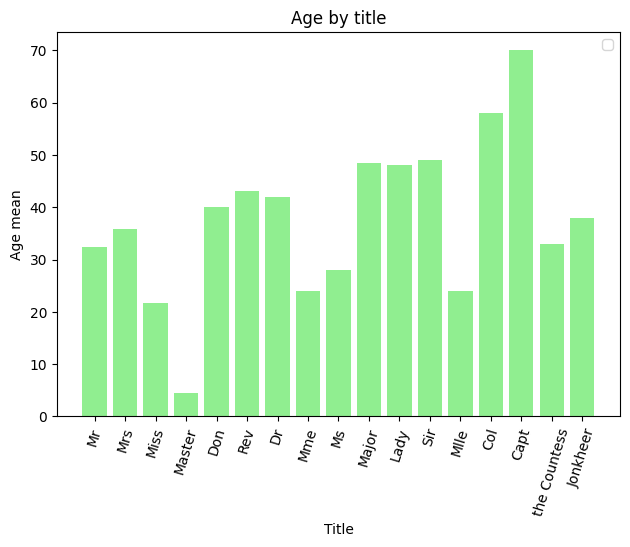

In [3]:
def visualize_nan_age(dataset):
    dataset['Title'] = dataset['Name'].apply(lambda x : x.split(', ')[1].split('. ')[0])
    titles_dict = {k: title for k, title in enumerate(dataset['Title'].unique())}
    dataset['Title'].replace([title for title in titles_dict.values()], [k for k in titles_dict.keys()], inplace=True)
    title_mean_age = dataset.groupby('Title')['Age'].mean()
    title_mean_age.index = title_mean_age.index.map(titles_dict)
    return title_mean_age

age_by_title = visualize_nan_age(train_set)
plt.bar(age_by_title.index, age_by_title, color='lightgreen')
plt.title('Age by title')
plt.ylabel('Age mean')
plt.xlabel('Title')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=73)
plt.show()


In [4]:
def fill_age(raw_dataset, title : int, title_mean_age):
    if not pd.isna(title_mean_age[title]):
        return title_mean_age[title]
    else:
        return raw_dataset['Age'].mean()

def estimate_nan_age(dataset, raw_dataset):
    dataset['Title'] = dataset['Name'].apply(lambda x : x.split(', ')[1].split('. ')[0])
    title_mean_age = dataset.groupby('Title')['Age'].mean()
    dataset['Age'] = dataset.apply(
    lambda row: fill_age(raw_dataset, row['Title'], title_mean_age) if pd.isna(row['Age']) else row['Age'],
    axis=1)
    return dataset

train_set = estimate_nan_age(train_set, train_set_raw)

# 4. Creating and training models

In [41]:
seed = 170

### 4.1 KNN :

In [57]:
def scale_dataset(dataset):
  X = dataset[['Pclass', 'Sex', 'Age', 'Family', 'Cabin_letter', 'Cabin_number']]
  scaler = MinMaxScaler()
  scaler.fit_transform(X)
  return X
X = scale_dataset(train_set)
y = train_set['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=seed)

param_grid = {
    'n_neighbors' : range(1, 20),
    'weights' : ['uniform', 'distance']
    }
best_params = {'n_neighbors': 7, 'weights': 'distance'}
model = KNeighborsClassifier(**best_params)
# model = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1)
model.fit(X_train, y_train)
print('Score of this model : ', model.score(X_test, y_test))
# print("Best params:", model.best_params_)

Score of this model :  0.7653631284916201


### 4.2 Random forest

Score of this model :  0.8491620111731844


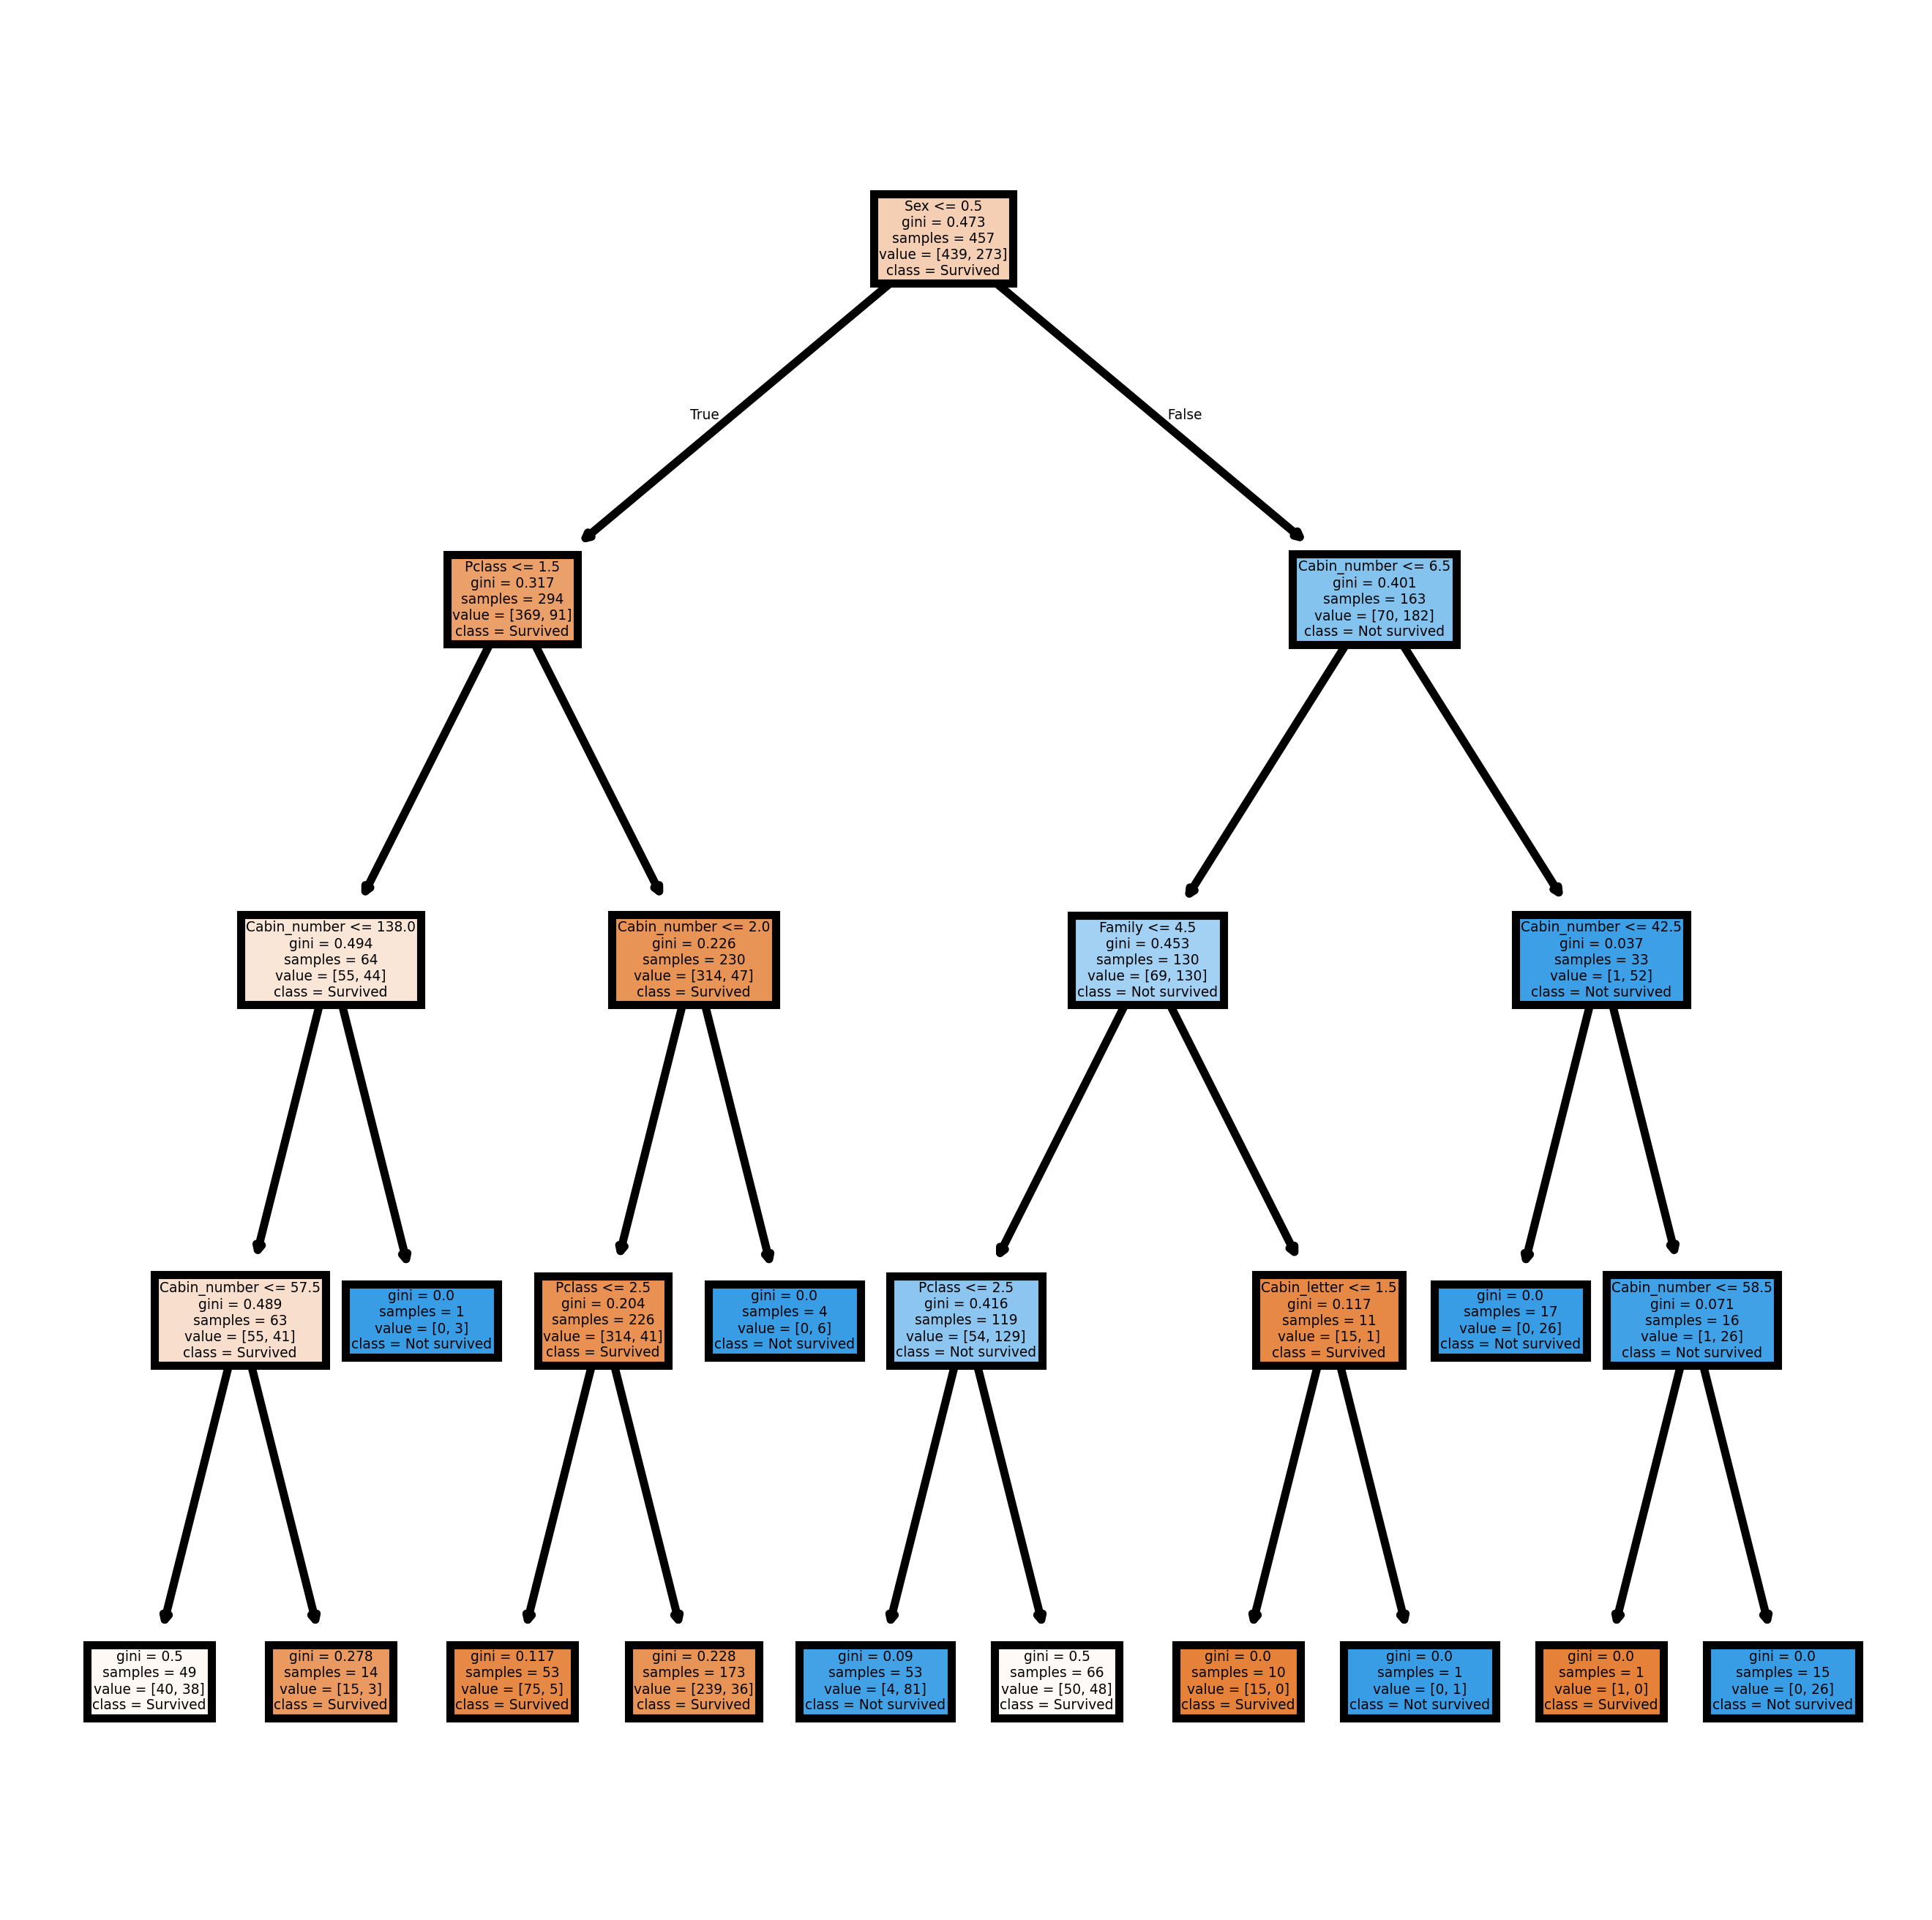

In [49]:
X = scale_dataset(train_set)
y = train_set['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=seed)

param_grid = {
    'n_estimators' : [3, 5, 7, 10, 15, 20, 25, 30],
    'criterion' : ["gini"],
    'min_samples_split' : range(2, 5),
    'min_samples_leaf' : range(1, 5),
    'max_depth' : range(1, 5)
    }
best_params = {'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 20}

model = RandomForestClassifier(**best_params)
# model = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1)
model.fit(X_train, y_train)
print('Score of this model : ', model.score(X_test, y_test))
# model.best_params_
fn=X_train.columns
cn=["Survived", "Not survived"]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(model.estimators_[2],
               feature_names = fn,
               class_names=cn,
               filled = True);

# 5. Predicting test_set

In [55]:
test_set = pd.read_csv('Data/test.csv')
test_set_formatted = format_dataset(test_set)
X_test = estimate_nan_age(test_set_formatted, test_set)
X_test = scale_dataset(X_test)
y_pred = model.predict(X_test)
submission = pd.DataFrame({'PassengerId' : test_set['PassengerId'], 'Survived' : y_pred})
submission.to_csv('submission.csv', index=False)

# *****************************
# Neural Network Approach :
# *****************************

## Implementation from scratch

In [8]:
seed = 42
train_set_raw = pd.read_csv("Data/train.csv")
train_set = train_set_raw.copy()
def format_dataset(dataset):
    X = dataset[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']]

    X['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
    X['Family'] = dataset['SibSp'] + dataset['Parch']
    X['Embarked'] = dataset['Embarked'].replace(['C', 'Q', 'S'], [0, 1, 2])
    X['Embarked'].fillna(X['Embarked'].mode()[0], inplace=True)

    X['Title'] = dataset['Name'].apply(lambda x : x.split(', ')[1].split('. ')[0])
    titles = [title for title in X['Title'].unique() if (X['Title'] == title).sum() > 0.02 * len(X)]
    X['Title'] = X['Title'].apply(lambda x : x if x in titles else 'Other')
    X['Title'].replace(titles + ['Other'], [k for k in range(len(titles) + 1)], inplace=True)

    title_mean_age = X.groupby('Title')['Age'].mean()
    X['Age'] = X.apply(
    lambda row: title_mean_age[row['Title']] if pd.isna(row['Age']) else row['Age'],
    axis=1)

    X.drop(['Title', 'SibSp', 'Parch'], axis=1, inplace=True)
    X = MinMaxScaler().fit_transform(X)
    return X

X = format_dataset(train_set)
y = train_set['Survived']
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, stratify=y, random_state=seed)
X_train, X_test, y_train, y_test = np.array(X_train.T), np.array(X_test.T), np.array(y_train), np.array(y_test)

In [3]:
def initialisation(dimensions):
    parametres = {}
    C = len(dimensions)

    for c in range(1, C):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c-1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)

    return parametres

def forward_propagation(X, parametres):
    activations = {'A0' : X}
    C = len(parametres) // 2
    for c in range(1, C + 1):
        Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
        activations['A' + str(c)] = 1 / (1 + np.exp(-Z))

    return activations

def back_propagation(y, activations, parametres):
    C = len(parametres) // 2
    m = y.shape[0]
    dZ = activations['A' + str(C)] - y
    gradients = {}

    for c in reversed(range(1, C + 1)):
        gradients['dW' + str(c)] = 1 / m * np.dot(dZ, activations['A' + str(c - 1)].T)
        gradients['db' + str(c)] = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        if c > 1:
            dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])

    return gradients

def update(gradients, parametres, learning_rate):
    C = len(parametres) // 2

    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]

    return parametres

def log_loss(y, activations):
    m = y.shape[0]
    return 1 / m * np.sum(-y * np.log(activations) - (1 - y) * np.log(1 - activations))

def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    C = len(parametres) // 2
    return activations['A' + str(C)] >= 0.5

def accuracy_score(y, y_pred):
    return np.mean(y == y_pred)

In [4]:
def neural_network(X, y, hidden_layers=(16, 16, 16), learning_rate = 0.1, n_iter = 100):
    np.random.seed(seed)
    dimensions = list(hidden_layers)
    dimensions.insert(0, X.shape[0])
    dimensions.append(1)
    parametres = initialisation(dimensions)
    train_loss = []
    train_acc =  []

    for i in tqdm(range(n_iter)):

        activations = forward_propagation(X, parametres)
        gradients = back_propagation(y, activations, parametres)
        parametres = update(gradients, parametres, learning_rate)
        if i % 10 == 0:
            C = len(parametres) // 2
            train_loss.append(log_loss(y, activations['A' + str(C)]))
            y_pred = predict(X, parametres)
            current_acc = accuracy_score(y, y_pred)
            train_acc.append(current_acc)

    # Visualisation
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
    ax[0].plot(train_loss, label='Training Loss')
    ax[0].legend()
    ax[0].set_xlabel('n_iter/10')
    ax[0].set_ylabel('Loss')

    ax[1].plot(train_acc, label='Training Accuracy')
    ax[1].legend()
    ax[1].set_xlabel('n_iter/10')
    ax[1].set_ylabel('Accuracy')

    plt.show()
    return parametres

100%|██████████| 20000/20000 [14:17<00:00, 23.32it/s] 


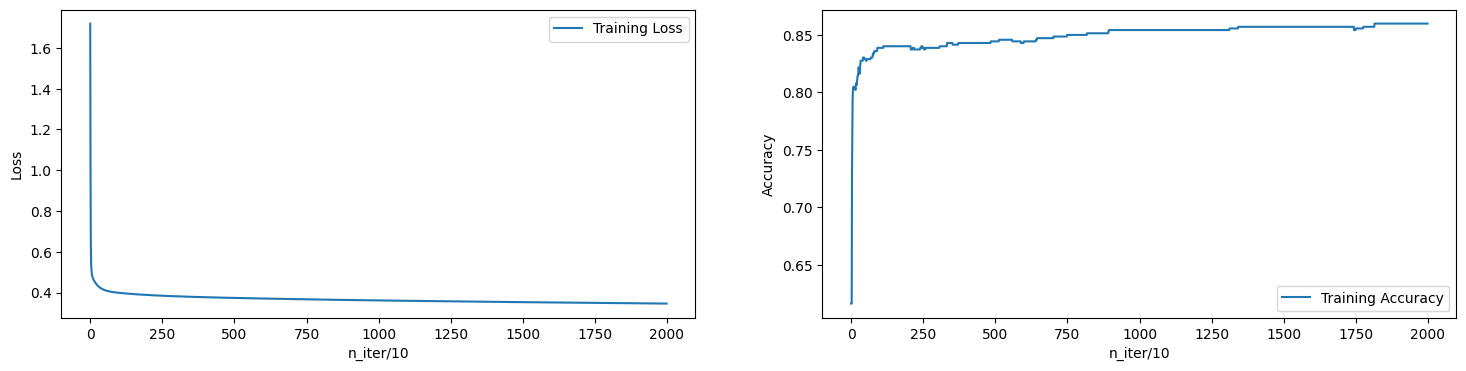

In [92]:
parametres = neural_network(X_train, y_train, hidden_layers=(512, 256, 128, 64, 32), learning_rate=0.01, n_iter=20000)
# Best score 0.79904 on Kaggle : hidden_layers=(512, 256, 128, 64, 32), learning_rate=0.01, n_iter=20000       ~14 min de compil

In [93]:
y_pred = predict(X_test, parametres)
print(accuracy_score(y_test, y_pred))

0.7988826815642458


In [95]:
test_set2 = pd.read_csv('Data/test.csv')
X_test2 = format_dataset(test_set2).T
y_pred = predict(X_test2, parametres)
submission = pd.DataFrame({'PassengerId' : test_set2['PassengerId'], 'Survived' : y_pred[0].astype(int)})
submission.to_csv('submission_deep_learning.csv', index=False)